In [4]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- 1. Helper Function to Create Gabor Kernels in PyTorch ---

def create_gabor_kernel(theta, frequency, sigma, kernel_size, device='cpu'):
    """Creates a complex Gabor filter kernel as a PyTorch tensor."""
    y, x = torch.meshgrid(
        [torch.linspace(-1., 1., kernel_size),
         torch.linspace(-1., 1., kernel_size)],
        indexing='ij'
    )
    x = x.to(device)
    y = y.to(device)

    # Rotate coordinates
    x_theta = x * torch.cos(theta) + y * torch.sin(theta)
    y_theta = -x * torch.sin(theta) + y * torch.cos(theta)

    # Gaussian envelope
    sigma_tensor = torch.tensor(sigma, device=device)
    gb = torch.exp(-.5 * (x_theta**2 / sigma_tensor**2 + y_theta**2 / sigma_tensor**2))

    # Sinusoid
    sinusoid = torch.exp(1j * 2 * np.pi * frequency * x_theta)

    # Gabor filter (complex)
    gabor_kernel = gb * sinusoid

    # Return real and imaginary parts
    return torch.real(gabor_kernel), torch.imag(gabor_kernel)


# --- 2. The Core PyTorch Feature Extraction Function ---

def extract_klein_bottle_coords_torch(patches, num_orientations=16, gabor_frequency=0.6, device='cpu'):
    """
    Calculates (theta, phi, polarity) for a batch of patches using PyTorch.

    Args:
        patches (torch.Tensor): A batch of patches with shape (N, C, H, W).
        num_orientations (int): Number of orientations to test.
        gabor_frequency (float): Frequency for the Gabor filter.
        device (str): 'cpu' or 'cuda'.

    Returns:
        list[dict]: A list of dictionaries, one for each patch, containing
                    'theta', 'phi', 'polarity', and 'magnitude'.
    """
    n_patches, n_channels, patch_height, patch_width = patches.shape

    patches_gray = torch.mean(patches.float(), dim=1, keepdim=True)
    patches_gray = patches_gray - patches_gray.mean(dim=[-1, -2], keepdim=True)
    patches_gray = patches_gray.to(device)

    # --- Create a bank of Gabor filters ---
    # CORRECTED LINE: Use arange for [0, pi) interval
    orientations = torch.arange(num_orientations, device=device) * (np.pi / num_orientations)

    gabor_kernels_real = []
    gabor_kernels_imag = []

    for theta in orientations:
        real, imag = create_gabor_kernel(
            theta=theta,
            frequency=gabor_frequency,
            sigma=0.5,
            kernel_size=patch_height,
            device=device
        )
        gabor_kernels_real.append(real)
        gabor_kernels_imag.append(imag)

    kernel_stack = torch.cat([
        torch.stack(gabor_kernels_real),
        torch.stack(gabor_kernels_imag)
    ], dim=0).unsqueeze(1)

    responses = F.conv2d(patches_gray, kernel_stack, padding='same')

    real_responses = responses[:, :num_orientations, ...].sum(dim=[-1, -2])
    imag_responses = responses[:, num_orientations:, ...].sum(dim=[-1, -2])

    magnitudes = torch.sqrt(real_responses**2 + imag_responses**2)
    max_magnitudes, best_indices = torch.max(magnitudes, dim=1)

    results = []
    for i in range(n_patches):
        best_idx = best_indices[i]

        real_part = real_responses[i, best_idx]
        imag_part = imag_responses[i, best_idx]

        theta = orientations[best_idx].item()
        phi = torch.atan2(imag_part, real_part).item() # Use atan2 for correct phase
        polarity = torch.sign(real_part).item()
        if polarity == 0: polarity = 1.0

        results.append({
            'theta': theta,
            'phi': phi,
            'polarity': polarity,
            'magnitude': max_magnitudes[i].item()
        })

    return results

# --- 3. Visualization Function (same as before) ---
def visualize_coords_on_image(image_tensor, all_coords, patch_size):
    """
    Overlays the calculated coordinates onto the original image for visualization.
    """
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image_np)
    ax.set_title("Klein Bottle Coordinates Visualization (PyTorch)", fontsize=16)

    norm = mcolors.Normalize(vmin=-np.pi, vmax=np.pi)
    cmap = plt.get_cmap('hsv')

    num_patches_y = image_tensor.shape[1] // patch_size
    num_patches_x = image_tensor.shape[2] // patch_size
    arrow_length = patch_size * 0.4

    max_magnitude = max(c['magnitude'] for c in all_coords) if all_coords else 1.0

    for i, coords in enumerate(all_coords):
        y_idx, x_idx = i // num_patches_x, i % num_patches_x
        center_x, center_y = (x_idx * patch_size) + patch_size / 2, (y_idx * patch_size) + patch_size / 2

        if coords['magnitude'] < 0.1 * max_magnitude: continue

        theta, phi, polarity = coords['theta'], coords['phi'], coords['polarity']
        dx, dy = arrow_length * np.cos(theta), -arrow_length * np.sin(theta)
        arrow_color, edge_color = cmap(norm(phi)), 'white' if polarity > 0 else 'black'

        ax.arrow(
            center_x - dx, center_y - dy, 2 * dx, 2 * dy,
            head_width=3, head_length=3, linewidth=1.5,
            facecolor=arrow_color, edgecolor=edge_color, length_includes_head=True
        )

    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('φ (Phase)', rotation=270, labelpad=15, fontsize=12)
    cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.set_ticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    plt.show()


Using device: cpu
Processing a 32x32 image into 64 patches of size 4x4...
Feature extraction complete. Generating visualization...


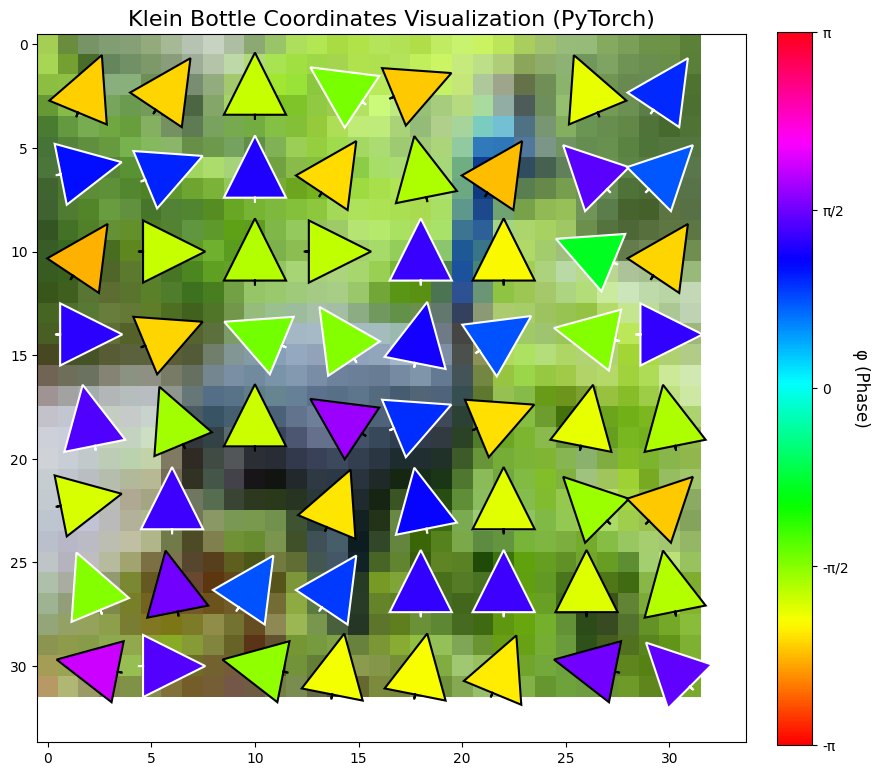

In [7]:
device = 'cpu'
print(f"Using device: {device}")

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
sample_image, _ = cifar_trainset[6]
transform = torchvision.transforms.ToTensor()
sample_image_tensor = transform(sample_image)

patch_size = 4
patches = sample_image_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
patches = patches.contiguous().view(-1, 3, patch_size, patch_size)

print(f"Processing a {sample_image_tensor.shape[1]}x{sample_image_tensor.shape[2]} image into {patches.shape[0]} patches of size {patch_size}x{patch_size}...")

all_coords = extract_klein_bottle_coords_torch(patches, device=device)

print("Feature extraction complete. Generating visualization...")

visualize_coords_on_image(sample_image_tensor, all_coords, patch_size)

In [8]:
_

2

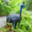

In [9]:
sample_image

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# We can reuse the Gabor kernel creator from our previous script
def create_gabor_kernel(theta, frequency, sigma, kernel_size, device='cpu'):
    """Creates a complex Gabor filter kernel as a PyTorch tensor."""
    y, x = torch.meshgrid(
        [torch.linspace(-1., 1., kernel_size),
         torch.linspace(-1., 1., kernel_size)],
        indexing='ij'
    )
    x = x.to(device)
    y = y.to(device)
    # Rotate coordinates
    x_theta = x * torch.cos(theta) + y * torch.sin(theta)
    y_theta = -x * torch.sin(theta) + y * torch.cos(theta)
    # Gaussian envelope
    sigma_tensor = torch.tensor(sigma, device=device)
    gb = torch.exp(-.5 * (x_theta**2 / sigma_tensor**2 + y_theta**2 / sigma_tensor**2))
    # Sinusoid
    sinusoid = torch.exp(1j * 2 * np.pi * frequency * x_theta)
    # Gabor filter (complex)
    gabor_kernel = gb * sinusoid
    return gabor_kernel

# --- The Inverse Map Implementation ---

def generate_canonical_patch(theta, phi, polarity, patch_size=16, frequency=0.6, device='cpu'):
    """
    Generates an ideal patch for a given (theta, phi, polarity) coordinate.
    This is the inverse map.

    Args:
        theta (float): Orientation in radians.
        phi (float): Phase in radians.
        polarity (int): +1 or -1.
        patch_size (int): The desired size of the output patch.
        frequency (float): The Gabor frequency.
        device (str): 'cpu' or 'cuda'.

    Returns:
        torch.Tensor: A (patch_size, patch_size) tensor representing the ideal patch.
    """
    # Step 1: Generate the base complex Gabor patch for the given theta
    # This represents (theta, phi=0, polarity=+1)
    base_gabor_complex = create_gabor_kernel(
        theta=torch.tensor(theta),
        frequency=frequency,
        sigma=0.5,
        kernel_size=patch_size,
        device=device
    )

    # Step 2: Apply the phase shift (phi)
    # We do this by multiplying by e^(i*phi)
    phase_shifter = torch.exp(1j * torch.tensor(phi, device=device))
    phased_gabor_complex = base_gabor_complex * phase_shifter

    # Step 3: Extract the real part and apply polarity
    # The real part is the visual pattern
    final_patch_real = torch.real(phased_gabor_complex) * polarity

    # Step 4: Normalize the patch for visualization (e.g., to [0, 1] range)
    min_val = torch.min(final_patch_real)
    max_val = torch.max(final_patch_real)
    if max_val > min_val:
        normalized_patch = (final_patch_real - min_val) / (max_val - min_val)
    else:
        normalized_patch = torch.zeros_like(final_patch_real)

    return normalized_patch

/tmp/ipykernel_790444/3745964604.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


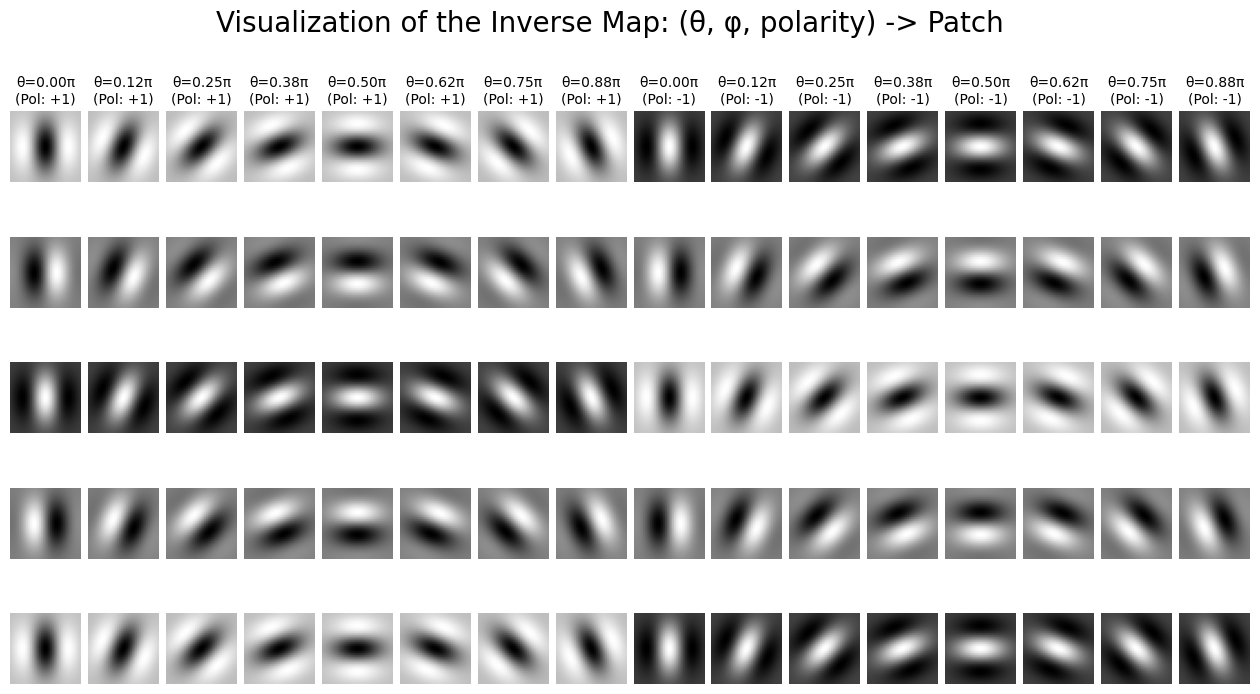

In [3]:
# --- Visualization of the Inverse Map ---

device = 'cpu'

# We will sample the Klein Bottle space and plot the corresponding patches
num_thetas = 8
num_phis = 5

thetas = np.linspace(0, np.pi, num_thetas, endpoint=False)
phis = np.linspace(-np.pi, np.pi, num_phis)

# Create a figure to display the grid of patches
# We'll show positive polarity on the left and negative on the right
fig, axes = plt.subplots(
    num_phis, num_thetas * 2,
    figsize=(16, 8),
    gridspec_kw={'wspace': 0.1, 'hspace': 0.1}
)

fig.suptitle("Visualization of the Inverse Map: (θ, φ, polarity) -> Patch", fontsize=20)

for i, phi in enumerate(phis):
    for j, theta in enumerate(thetas):
        # --- Positive Polarity ---
        patch_pos = generate_canonical_patch(theta, phi, +1, patch_size=32, device=device)
        ax_pos = axes[i, j]
        ax_pos.imshow(patch_pos.cpu().numpy(), cmap='gray')
        ax_pos.axis('off')

        # --- Negative Polarity ---
        patch_neg = generate_canonical_patch(theta, phi, -1, patch_size=32, device=device)
        ax_neg = axes[i, j + num_thetas] # Plot in the right-hand grid
        ax_neg.imshow(patch_neg.cpu().numpy(), cmap='gray')
        ax_neg.axis('off')

# Add labels
for j, theta in enumerate(thetas):
    axes[0, j].set_title(f"θ={theta/np.pi:.2f}π\n(Pol: +1)", fontsize=10)
    axes[0, j + num_thetas].set_title(f"θ={theta/np.pi:.2f}π\n(Pol: -1)", fontsize=10)

for i, phi in enumerate(phis):
    axes[i, 0].set_ylabel(f"φ={phi/np.pi:.2f}π", rotation=90, size='large')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Loading CIFAR-10 image #6...
Image patched into 64 patches of size 4x4.
Projecting patches to Klein Bottle coordinates...
Generating ideal patches from coordinates (inverse map)...
Reconstructing image from ideal patches...
Displaying results...


/tmp/ipykernel_790444/2173094813.py:37: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  responses = F.conv2d(patches_gray, kernel_stack, padding='same')


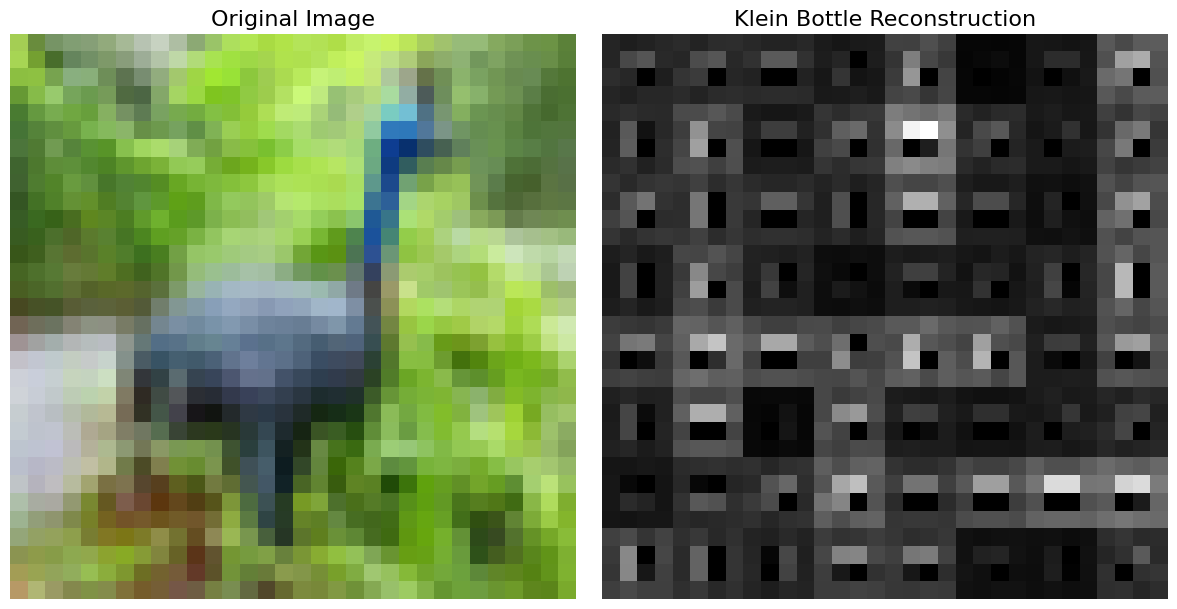

In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --- Re-using our previously defined helper functions ---

def create_gabor_kernel(theta, frequency, sigma, kernel_size, device='cpu'):
    """Creates a complex Gabor filter kernel as a PyTorch tensor."""
    y, x = torch.meshgrid(
        [torch.linspace(-1., 1., kernel_size),
         torch.linspace(-1., 1., kernel_size)],
        indexing='ij'
    )
    x, y = x.to(device), y.to(device)
    x_theta = x * torch.cos(theta) + y * torch.sin(theta)
    y_theta = -x * torch.sin(theta) + y * torch.cos(theta)
    sigma_tensor = torch.tensor(sigma, device=device)
    gb = torch.exp(-.5 * (x_theta**2 / sigma_tensor**2 + y_theta**2 / sigma_tensor**2))
    sinusoid = torch.exp(1j * 2 * np.pi * frequency * x_theta)
    return gb * sinusoid

def extract_klein_bottle_coords_torch(patches, num_orientations=16, gabor_frequency=0.6, device='cpu'):
    """Forward Map: (Batch of Patches) -> (List of Coordinates)"""
    n_patches, _, patch_height, _ = patches.shape
    patches_gray = torch.mean(patches.float(), dim=1, keepdim=True)
    patches_gray = patches_gray - patches_gray.mean(dim=[-1, -2], keepdim=True)
    patches_gray = patches_gray.to(device)

    orientations = torch.arange(num_orientations, device=device) * (np.pi / num_orientations)

    gabor_kernels_real = [torch.real(create_gabor_kernel(th, gabor_frequency, 0.5, patch_height, device)) for th in orientations]
    gabor_kernels_imag = [torch.imag(create_gabor_kernel(th, gabor_frequency, 0.5, patch_height, device)) for th in orientations]
    kernel_stack = torch.cat([torch.stack(gabor_kernels_real), torch.stack(gabor_kernels_imag)], dim=0).unsqueeze(1)

    responses = F.conv2d(patches_gray, kernel_stack, padding='same')
    real_responses = responses[:, :num_orientations, ...].sum(dim=[-1, -2])
    imag_responses = responses[:, num_orientations:, ...].sum(dim=[-1, -2])

    magnitudes = torch.sqrt(real_responses**2 + imag_responses**2)
    max_magnitudes, best_indices = torch.max(magnitudes, dim=1)

    results = []
    for i in range(n_patches):
        best_idx = best_indices[i]
        real_part, imag_part = real_responses[i, best_idx], imag_responses[i, best_idx]
        polarity = torch.sign(real_part).item()
        results.append({
            'theta': orientations[best_idx].item(),
            'phi': torch.atan2(imag_part, real_part).item(),
            'polarity': 1.0 if polarity == 0 else polarity,
            'magnitude': max_magnitudes[i].item()
        })
    return results

def generate_canonical_patch(theta, phi, polarity, patch_size=16, frequency=0.6, device='cpu'):
    """Inverse Map: (Coordinates) -> (Ideal Patch)"""
    base_gabor_complex = create_gabor_kernel(torch.tensor(theta), frequency, 0.5, patch_size, device)
    phase_shifter = torch.exp(1j * torch.tensor(phi, device=device))
    phased_gabor_complex = base_gabor_complex * phase_shifter
    final_patch_real = torch.real(phased_gabor_complex) * polarity

    # Normalize to [0, 1] range. This is important for visualization.
    min_val, max_val = torch.min(final_patch_real), torch.max(final_patch_real)
    return (final_patch_real - min_val) / (max_val - min_val) if max_val > min_val else torch.zeros_like(final_patch_real)

    # --- Configuration ---
device = 'cpu'
patch_size = 4
image_index = 6 # 6=frog, 0=horse, 3=cat, 7=car

# --- Step 1: Load and Patch the Image ---
print(f"Loading CIFAR-10 image #{image_index}...")
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
pil_image, _ = cifar_trainset[image_index]
transform = torchvision.transforms.ToTensor()
image_tensor = transform(pil_image).to(device) # Shape: (C, H, W)

# Use unfold to get non-overlapping patches
original_patches = image_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
original_patches = original_patches.contiguous().view(-1, 3, patch_size, patch_size)
print(f"Image patched into {original_patches.shape[0]} patches of size {patch_size}x{patch_size}.")

# --- Step 2: Forward Projection (Image -> Coordinates) ---
print("Projecting patches to Klein Bottle coordinates...")
all_coords = extract_klein_bottle_coords_torch(original_patches, device=device)

# --- Step 3: Inverse Projection (Coordinates -> Ideal Patches) ---
print("Generating ideal patches from coordinates (inverse map)...")
reconstructed_patches = []
max_magnitude = max(c['magnitude'] for c in all_coords) if all_coords else 1.0
for coords in all_coords:
    # Generate the ideal patch
    ideal_patch = generate_canonical_patch(
        coords['theta'], coords['phi'], coords['polarity'],
        patch_size=patch_size, device=device
    )
    # We can optionally scale the patch's intensity by its original magnitude
    # This makes strong features bright and weak features dark
    intensity_scale = coords['magnitude'] / max_magnitude
    reconstructed_patches.append(ideal_patch * intensity_scale)

# --- Step 4: Assemble the New Image from Ideal Patches ---
print("Reconstructing image from ideal patches...")
num_patches_y = image_tensor.shape[1] // patch_size
num_patches_x = image_tensor.shape[2] // patch_size

# Create an empty canvas for the new image
reconstructed_image = torch.zeros_like(image_tensor)

for i, patch in enumerate(reconstructed_patches):
    # Calculate the 2D grid position from the flat index
    y_idx = i // num_patches_x
    x_idx = i % num_patches_x

    # Calculate the pixel coordinates for placing the patch
    y_start, x_start = y_idx * patch_size, x_idx * patch_size
    y_end, x_end = y_start + patch_size, x_start + patch_size

    # Place the grayscale patch into all 3 color channels of the canvas
    reconstructed_image[:, y_start:y_end, x_start:x_end] = patch.unsqueeze(0)

# --- Step 5: Visualization ---
print("Displaying results...")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
axes[0].imshow(image_tensor.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original Image", fontsize=16)
axes[0].axis('off')

# Reconstructed Image
axes[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().numpy())
axes[1].set_title("Klein Bottle Reconstruction", fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()


Loading CIFAR-10 image #3...
Image patched into 100 patches of size 3x3.
Projecting patches and generating ideal reconstructions...
Reconstructing image from ideal patches...
Displaying results...


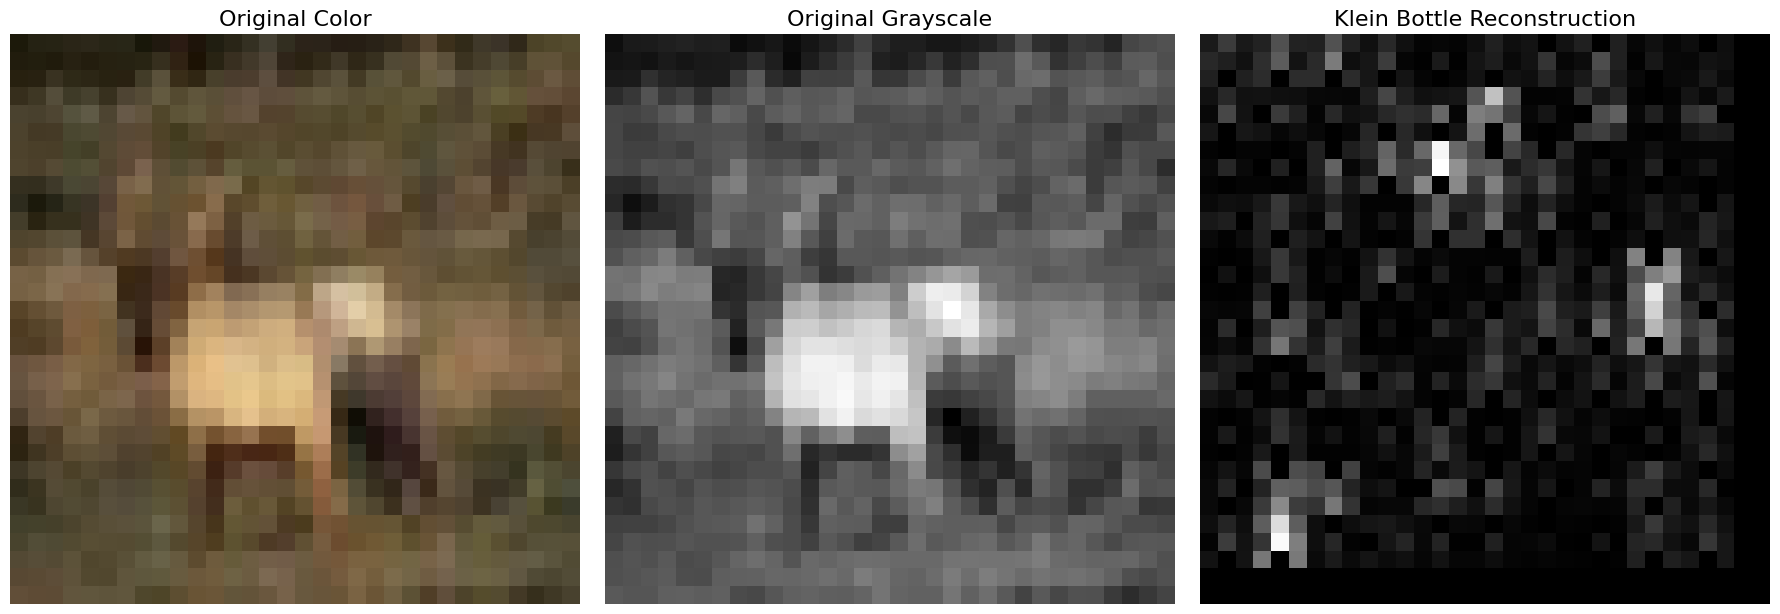

In [9]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# --- Re-using our previously defined helper functions ---

def create_gabor_kernel(theta, frequency, sigma, kernel_size, device='cpu'):
    """Creates a complex Gabor filter kernel as a PyTorch tensor."""
    y, x = torch.meshgrid(
        [torch.linspace(-1., 1., kernel_size),
         torch.linspace(-1., 1., kernel_size)],
        indexing='ij'
    )
    x, y = x.to(device), y.to(device)
    x_theta = x * torch.cos(theta) + y * torch.sin(theta)
    y_theta = -x * torch.sin(theta) + y * torch.cos(theta)
    sigma_tensor = torch.tensor(sigma, device=device)
    gb = torch.exp(-.5 * (x_theta**2 / sigma_tensor**2 + y_theta**2 / sigma_tensor**2))
    sinusoid = torch.exp(1j * 2 * np.pi * frequency * x_theta)
    return gb * sinusoid

def extract_klein_bottle_coords_torch(patches, num_orientations=64, gabor_frequency=0.6, device='cpu'):
    """Forward Map: (Batch of Patches) -> (List of Coordinates)"""
    n_patches, _, patch_height, _ = patches.shape
    patches_gray = torch.mean(patches.float(), dim=1, keepdim=True)
    patches_gray = patches_gray - patches_gray.mean(dim=[-1, -2], keepdim=True)
    patches_gray = patches_gray.to(device)

    orientations = torch.arange(num_orientations, device=device) * (np.pi / num_orientations)

    gabor_kernels = [create_gabor_kernel(th, gabor_frequency, 0.5, patch_height, device) for th in orientations]
    kernel_stack = torch.cat([torch.stack([torch.real(k) for k in gabor_kernels]),
                              torch.stack([torch.imag(k) for k in gabor_kernels])], dim=0).unsqueeze(1)

    responses = F.conv2d(patches_gray, kernel_stack, padding='same')
    real_responses = responses[:, :num_orientations, ...].sum(dim=[-1, -2])
    imag_responses = responses[:, num_orientations:, ...].sum(dim=[-1, -2])

    magnitudes = torch.sqrt(real_responses**2 + imag_responses**2)
    max_magnitudes, best_indices = torch.max(magnitudes, dim=1)

    results = []
    for i in range(n_patches):
        best_idx = best_indices[i]
        real_part, imag_part = real_responses[i, best_idx], imag_responses[i, best_idx]
        polarity = torch.sign(real_part).item()
        results.append({
            'theta': orientations[best_idx].item(),
            'phi': torch.atan2(imag_part, real_part).item(),
            'polarity': 1.0 if polarity == 0 else polarity,
            'magnitude': max_magnitudes[i].item()
        })
    return results

def generate_canonical_patch(theta, phi, polarity, patch_size=16, frequency=0.6, device='cpu'):
    """Inverse Map: (Coordinates) -> (Ideal Patch)"""
    base_gabor_complex = create_gabor_kernel(torch.tensor(theta), frequency, 0.5, patch_size, device)
    phase_shifter = torch.exp(1j * torch.tensor(phi, device=device))
    phased_gabor_complex = base_gabor_complex * phase_shifter
    final_patch_real = torch.real(phased_gabor_complex) * polarity

    min_val, max_val = torch.min(final_patch_real), torch.max(final_patch_real)
    return (final_patch_real - min_val) / (max_val - min_val) if max_val > min_val else torch.zeros_like(final_patch_real)

# --- Main Execution Script ---

# --- Configuration ---
device = 'cpu'
patch_size = 3
image_index = 3 # 6=frog, 0=horse, 3=cat, 7=car

# --- Step 1: Load and Patch the Image ---
print(f"Loading CIFAR-10 image #{image_index}...")
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
pil_image, _ = cifar_trainset[image_index]

# Create color tensor
to_tensor = torchvision.transforms.ToTensor()
image_tensor_color = to_tensor(pil_image).to(device)

# *** NEW: Create grayscale tensor for comparison ***
to_grayscale = torchvision.transforms.Grayscale()
image_tensor_gray = to_grayscale(image_tensor_color)

# Patch the original color image
original_patches = image_tensor_color.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
original_patches = original_patches.contiguous().view(-1, 3, patch_size, patch_size)
print(f"Image patched into {original_patches.shape[0]} patches of size {patch_size}x{patch_size}.")

# --- Step 2 & 3: Forward and Inverse Projection ---
print("Projecting patches and generating ideal reconstructions...")
all_coords = extract_klein_bottle_coords_torch(original_patches, device=device)

reconstructed_patches = []
max_magnitude = max(c['magnitude'] for c in all_coords) if all_coords else 1.0
for coords in all_coords:
    ideal_patch = generate_canonical_patch(
        coords['theta'], coords['phi'], coords['polarity'],
        patch_size=patch_size, device=device
    )
    intensity_scale = coords['magnitude'] / max_magnitude
    reconstructed_patches.append(ideal_patch * intensity_scale)

# --- Step 4: Assemble the New Image ---
print("Reconstructing image from ideal patches...")
num_patches_y = image_tensor_color.shape[1] // patch_size
num_patches_x = image_tensor_color.shape[2] // patch_size
reconstructed_image = torch.zeros_like(image_tensor_gray) # Canvas should be grayscale

for i, patch in enumerate(reconstructed_patches):
    y_idx, x_idx = i // num_patches_x, i % num_patches_x
    y_start, x_start = y_idx * patch_size, x_idx * patch_size
    y_end, x_end = y_start + patch_size, x_start + patch_size
    reconstructed_image[0, y_start:y_end, x_start:x_end] = patch

# --- Step 5: Visualization (Updated for 1x3 layout) ---
print("Displaying results...")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Color
axes[0].imshow(image_tensor_color.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original Color", fontsize=16)
axes[0].axis('off')

# Plot 2: Original Grayscale
axes[1].imshow(image_tensor_gray.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title("Original Grayscale", fontsize=16)
axes[1].axis('off')

# Plot 3: Klein Bottle Reconstruction
axes[2].imshow(reconstructed_image.squeeze().cpu().numpy(), cmap='gray')
axes[2].set_title("Klein Bottle Reconstruction", fontsize=16)
axes[2].axis('off')

plt.tight_layout()
plt.show()


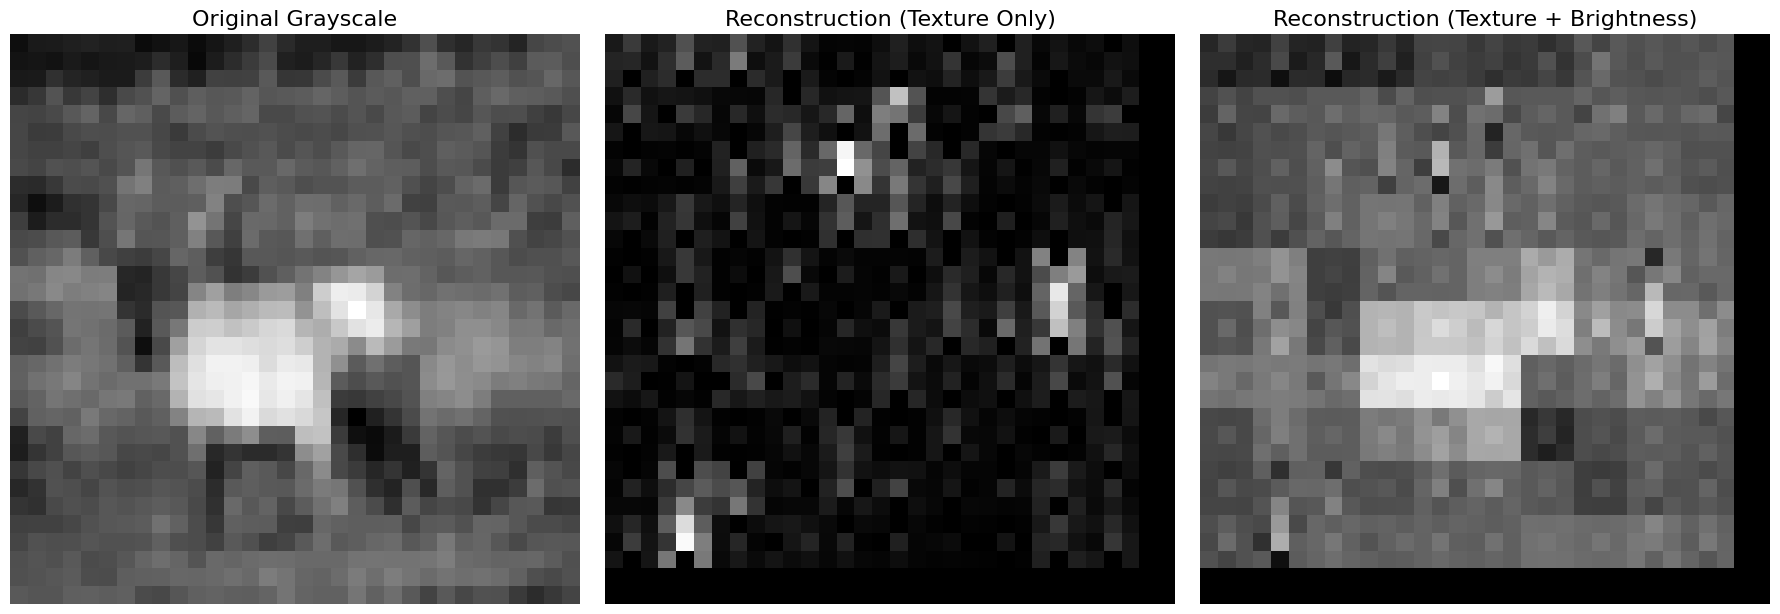

In [11]:
# --- (All helper functions remain the same as the previous script) ---
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt

def create_gabor_kernel(theta, frequency, sigma, kernel_size, device='cpu'):
    y, x = torch.meshgrid(
        [torch.linspace(-1., 1., kernel_size),
         torch.linspace(-1., 1., kernel_size)],
        indexing='ij'
    )
    x, y = x.to(device), y.to(device)
    x_theta = x * torch.cos(theta) + y * torch.sin(theta)
    y_theta = -x * torch.sin(theta) + y * torch.cos(theta)
    sigma_tensor = torch.tensor(sigma, device=device)
    gb = torch.exp(-.5 * (x_theta**2 / sigma_tensor**2 + y_theta**2 / sigma_tensor**2))
    sinusoid = torch.exp(1j * 2 * np.pi * frequency * x_theta)
    return gb * sinusoid

def extract_klein_bottle_coords_torch(patches, num_orientations=16, gabor_frequency=0.6, device='cpu'):
    n_patches, _, patch_height, _ = patches.shape
    patches_gray = torch.mean(patches.float(), dim=1, keepdim=True)
    patches_gray = patches_gray - patches_gray.mean(dim=[-1, -2], keepdim=True)
    patches_gray = patches_gray.to(device)
    orientations = torch.arange(num_orientations, device=device) * (np.pi / num_orientations)
    gabor_kernels = [create_gabor_kernel(th, gabor_frequency, 0.5, patch_height, device) for th in orientations]
    kernel_stack = torch.cat([torch.stack([torch.real(k) for k in gabor_kernels]),
                              torch.stack([torch.imag(k) for k in gabor_kernels])], dim=0).unsqueeze(1)
    responses = F.conv2d(patches_gray, kernel_stack, padding='same')
    real_responses = responses[:, :num_orientations, ...].sum(dim=[-1, -2])
    imag_responses = responses[:, num_orientations:, ...].sum(dim=[-1, -2])
    magnitudes = torch.sqrt(real_responses**2 + imag_responses**2)
    max_magnitudes, best_indices = torch.max(magnitudes, dim=1)
    results = []
    for i in range(n_patches):
        best_idx = best_indices[i]
        real_part, imag_part = real_responses[i, best_idx], imag_responses[i, best_idx]
        polarity = torch.sign(real_part).item()
        results.append({
            'theta': orientations[best_idx].item(), 'phi': torch.atan2(imag_part, real_part).item(),
            'polarity': 1.0 if polarity == 0 else polarity, 'magnitude': max_magnitudes[i].item()
        })
    return results

def generate_canonical_patch(theta, phi, polarity, patch_size=16, frequency=0.6, device='cpu'):
    base_gabor_complex = create_gabor_kernel(torch.tensor(theta), frequency, 0.5, patch_size, device)
    phase_shifter = torch.exp(1j * torch.tensor(phi, device=device))
    phased_gabor_complex = base_gabor_complex * phase_shifter
    final_patch_real = torch.real(phased_gabor_complex) * polarity
    min_val, max_val = torch.min(final_patch_real), torch.max(final_patch_real)
    return (final_patch_real - min_val) / (max_val - min_val) if max_val > min_val else torch.zeros_like(final_patch_real)


# --- Main Execution Script (Updated) ---
device = 'cpu'
patch_size = 3
image_index = 3 # 6=frog, 0=horse, 3=cat, 7=car

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
pil_image, _ = cifar_trainset[image_index]
to_tensor = torchvision.transforms.ToTensor()
image_tensor_color = to_tensor(pil_image).to(device)
image_tensor_gray = torchvision.transforms.Grayscale()(image_tensor_color)

original_color_patches = image_tensor_color.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
original_color_patches = original_color_patches.contiguous().view(-1, 3, patch_size, patch_size)

# *** NEW: Get original grayscale patches to extract their mean brightness ***
original_gray_patches = image_tensor_gray.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
original_gray_patches = original_gray_patches.contiguous().view(-1, 1, patch_size, patch_size)

all_coords = extract_klein_bottle_coords_torch(original_color_patches, device=device)

# --- MODIFIED: Two types of reconstruction ---
reconstructed_patches_ac_only = [] # AC only (texture, the "skeleton")
reconstructed_patches_ac_dc = []   # AC + DC (texture + original brightness)

max_magnitude = max(c['magnitude'] for c in all_coords) if all_coords else 1.0

for i, coords in enumerate(all_coords):
    ideal_patch = generate_canonical_patch(
        coords['theta'], coords['phi'], coords['polarity'],
        patch_size=patch_size, device=device
    )

    # Scale texture intensity by Gabor magnitude
    texture_intensity = (coords['magnitude'] / max_magnitude) * 0.5 # Scale magnitude effect

    # Version 1: AC only (what we had before)
    ac_only_patch = ideal_patch * texture_intensity
    reconstructed_patches_ac_only.append(ac_only_patch)

    # Version 2: AC + DC
    # Center the texture patch around 0
    texture_patch = (ideal_patch - 0.5) * texture_intensity
    # Get the original patch's mean brightness
    dc_component = original_gray_patches[i].mean()
    # Add them together and clip
    ac_dc_patch = torch.clamp(texture_patch + dc_component, 0, 1)
    reconstructed_patches_ac_dc.append(ac_dc_patch)

# --- Assemble both reconstructed images ---
num_patches_y = image_tensor_color.shape[1] // patch_size
num_patches_x = image_tensor_color.shape[2] // patch_size

recon_image_ac = torch.zeros_like(image_tensor_gray)
recon_image_ac_dc = torch.zeros_like(image_tensor_gray)

for i in range(len(all_coords)):
    y_idx, x_idx = i // num_patches_x, i % num_patches_x
    y_start, x_start = y_idx * patch_size, x_idx * patch_size
    y_end, x_end = y_start + patch_size, x_start + patch_size

    recon_image_ac[0, y_start:y_end, x_start:x_end] = reconstructed_patches_ac_only[i]
    recon_image_ac_dc[0, y_start:y_end, x_start:x_end] = reconstructed_patches_ac_dc[i]

# --- Visualization (Updated for 1x3 layout) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_tensor_gray.squeeze().cpu().numpy(), cmap='gray')
axes[0].set_title("Original Grayscale", fontsize=16)

axes[1].imshow(recon_image_ac.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title("Reconstruction (Texture Only)", fontsize=16)

axes[2].imshow(recon_image_ac_dc.squeeze().cpu().numpy(), cmap='gray')
axes[2].set_title("Reconstruction (Texture + Brightness)", fontsize=16)

for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()
